# Olist's Net Promoter Score (NPS) 🔥

The **Net Promoter Score (NPS)** of a service answers the following question:

> How likely is it that you would recommend our company/product/service to a friend or colleague?

For a service rated between 1 and 5 stars, like Olist, we can **classify customers into three categories** based on their answers:
- ✅ **Promoters**: customers who answered  with a score of 5
- 😴 **Passive**: customers who answered with a score of 4 
- 😡 **Detractors**: customers who answered with a score between 1 and 3 (inclusive)

<br>

👉 NPS is computed by subtracting the percentage of customers who are **detractors** from the percentage of customers who are **promoters**. The score can range between -100 and 100, where a negative score means that the number of Dectractors outweighs the Promoters, and the other way around.

> NPS  
= % Promoters - % Detractors   
= (# Promoter - # Detractors) / # Reviews  
= (# 5 stars - # <4 stars) / # Reviews

## Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from math import radians, sin, cos, asin, sqrt

In [2]:
root_path = os.path.join(os.getcwd(),'..')
if root_path not in sys.path:
    sys.path.append(root_path)

from utils.data import Olist
from utils.order import Order

olist_instance = Olist()
data = olist_instance.get_data()

order_instance = Order()
orders = order_instance.get_training_data()

## 1. Computing the Overall NPS Score of Olist

- `review_score` is **5** 👉 `nps_class` is **1** (promoter)
- `review_score` is **4** 👉 `nps_class` is **0** (passive)
- `review_score` is **3** or less 👉 `nps_class` is **-1** (detractor)

In [3]:
orders

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...
96356,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08
96357,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10
96358,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02
96359,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18


In [4]:
orders['promoter_score'] = orders['review_score'].apply(lambda x: 1 if x == 5 else (0 if x == 4 else -1))
nps = orders['promoter_score'].mean()

print(f'NPS = {nps*100:.1f}')

NPS = 38.1


# Orders

## Goal: Create a DataFrame with the following features

| feature_name           | type   | description                                                                                             |
|:-----------------------|:------:|:--------------------------------------------------------------------------------------------------------|
| `order_id`             | str    | the id of the order                                                                                     |
| `wait_time`            | float  | the number of days between order date and delivery date                                                 |
| `expected_wait_time`   | float  | the number of days between order_date and estimated_delivery_date                                       |
| `delay_vs_expected`    | float  | if the actual delivery date is later than the estimated delivery date, returns the number of days between the two dates, otherwise return 0 |
| `order_status`         | str    | the status of the order                                                                                 |
| `dim_is_five_star`     | int    | 1 if the order received a five-star review, 0 otherwise                                                 |
| `dim_is_one_star`      | int    | 1 if the order received a one-star review, 0 otherwise                                                  |
| `review_score`         | int    | from 1 to 5                                                                                             |
| `number_of_products`   | int    | number of products that the order contains                                                              |
| `number_of_sellers`    | int    | number of sellers involved in the order                                                                 |
| `price`                | float  | total price of the order paid by customer                                                               |
| `freight_value`        | float  | value of the freight paid by customer                                                                   |
| `distance_customer_seller` | float  | the distance in km between customer and seller                                                      |


💡 Methodology:
- Using the notebook below to write and test my code step-by-step first
- Then copying the code into `order.py` to make the dataframe importable to other notebooks
- Focus on the data manipulation logic now, I will analyse the dataset visually in the next step

In [5]:
# %load_ext autoreload
# %autoreload 2

# import os
# import sys
# import pandas as pd
# import numpy as np
# import seaborn as sns
# from math import radians, sin, cos, asin, sqrt

In [6]:
# root_path = os.path.join(os.getcwd(),'..')
# if root_path not in sys.path:
#     sys.path.append(root_path)

# from utils.data import Olist
# from utils.order import Order

# olist_instance = Olist()
# data = olist_instance.get_data()

# order_instance = Order()
# orders = order_instance.get_training_data()

## Code `order.py`

### a) Method: `get_wait_time`
❓ Return a Dataframe with:
       `order_id`, `wait_time`, `expected_wait_time`, `delay_vs_expected`, `order_status`


Pseudo-code below for this method:

1. Check the dataframe `oreders`
2. Filter the dataframe on `delivered orders`
3. Handle `datetime`
4. Compute `wait_time`
5. Compute `expected_wait_time`
6. Compute `delay_vs_expected`
7. Check the new dataframe
8. Export the code to to `utils/order.py`

In [7]:
orders = data['orders'].copy()
orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00


In [8]:
# Filter the dataframe on delivered orders
orders = orders.query("order_status == 'delivered'")

# Convert dates from "string" type to "pandas.datetime"
to_date_time_col = ['order_purchase_timestamp',
                    'order_delivered_customer_date',
                    'order_estimated_delivery_date']

orders[to_date_time_col] = orders[to_date_time_col].apply(pd.to_datetime)

# Variable for computation
one_day_delta = np.timedelta64(24, 'h')

# Compute wait_time and store it in a new column
orders['wait_time'] = \
    (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']) / one_day_delta

# Compute expected_wait_time and store it in a new column
orders['expected_wait_time'] = \
    (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']) / one_day_delta

# Compute delay_vs_expected and store it in a new column
orders['delay_vs_expected'] = \
    (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']) / one_day_delta
orders['delay_vs_expected'] = orders['delay_vs_expected'].clip(0)

orders = orders[['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected', 'order_status']]


In [9]:
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered


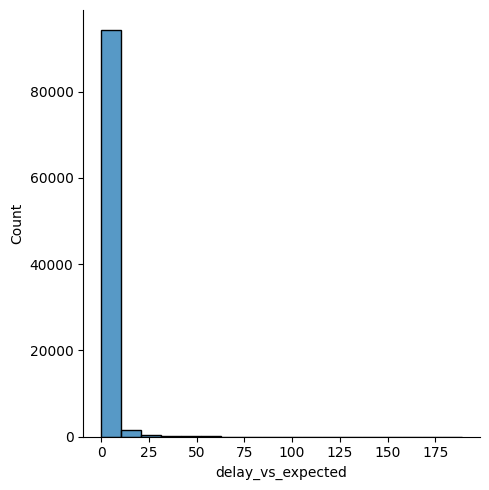

In [10]:
sns.displot(orders['delay_vs_expected'])

### b) Method: `get_review_score`
❓ Returns a DataFrame with:
  `order_id`, `dim_is_five_star`, `dim_is_one_star`, `review_score`


dim_is_$N$_star should contain `1` if review_score=$N$ and `0` otherwise  

Pseudo-code below for this method:

1. Check the dataframe `oreder_reviews`
2. Keep only needed columns `order_id` and `review_score`
3. Compute `dim_is_five_star`
4. Compute `dim_is_one_star`
5. Check the new dataframe
6. Export the code to to `utils/order.py`

In [11]:
reviews = data['order_reviews'].copy()
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [12]:
reviews = reviews[['order_id', 'review_score']]

# Compute dim_is_five_star and store it in a new column
reviews['dim_is_five_star'] = reviews.apply(lambda x: 1 if x['review_score'] == 5 else 0, axis=1)

# Compute dim_is_one_star and store it in a new column
reviews['dim_is_one_star'] = reviews.apply(lambda x: 1 if x['review_score'] == 1 else 0, axis=1)

In [13]:
reviews.head()

,order_id,review_score,dim_is_five_star,dim_is_one_star
0,73fc7af87114b39712e6da79b0a377eb,4,0,0
1,a548910a1c6147796b98fdf73dbeba33,5,1,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,1,0
3,658677c97b385a9be170737859d3511b,5,1,0
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,1,0


### c) Method: `get_number_products`:
❓ Returns a DataFrame with:
  `order_id`, `number_of_products` (total number of products per order)

Pseudo-code below for this method:

1. Check the dataframe `products` and `order_items`
2. Merge `products` and `order_items` dataframes
3. Group by `order_id` and count `product_id`
4. Rename columns
5. Check the new dataframe
6. Export the code to to `utils/order.py`

In [14]:
copy_products = data['products'].copy()
copy_products.head()


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [15]:
copy_order_items = data['order_items'].copy()
copy_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


products = pd.merge(temp, data['order_items'], how='left', on='product_id')
products['']


In [16]:
# Merge dataframes
products = pd.merge(copy_products, copy_order_items, how='left', on='product_id')

# Group by order_id and count number of product_id's
products = products.groupby(by='order_id')[['product_id']].count()

# Rename columns
products = products.rename(columns={'product_id': 'number_of_products'}).reset_index()

In [17]:
products

,order_id,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


In [18]:
products.describe()

,number_of_products
count,98666.000000
mean,1.141731
std,0.538452
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,21.000000


### d) Method: `get_number_sellers`:
❓ Returns a DataFrame with:
  `order_id`, `number_of_sellers` (total number of unique sellers per order)

Pseudo-code below for this method:

1. Check the dataframe `sellers` and `order_items`
2. Merge `sellers` and `order_items` dataframes
3. Group by `order_id` and count unique `seller_id`
4. Rename columns
5. Check the new dataframe
6. Export the code to to `utils/order.py`

In [19]:
copy_sellers = data['sellers'].copy()
copy_sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [20]:
copy_oder_items = data['order_items'].copy()
copy_oder_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [21]:
# Merge dataframes
sellers = pd.merge(copy_sellers, copy_oder_items, how='left', on='seller_id')

# Group by order_id and count unique seller_id's
sellers = sellers.groupby(by='order_id')[['seller_id']].nunique()

# Rename columns
sellers = sellers.rename(columns={'seller_id': 'number_of_sellers'}).reset_index()

In [22]:
sellers

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


In [23]:
sellers.describe()

,number_of_sellers
count,98666.000000
mean,1.013622
std,0.122297
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5.000000


### e) Method: `get_price_and_freight`
❓ Returns a DataFrame with:
    `order_id`, `price`, `freight_value`


Pseudo-code below for this method:

1. Check the dataframe `order_items`
2. Keep only needed columns `order_id`, `price` and `freight_value`
3. Group by `order_id` and sum `price` and `freight_value`
4. Check the new dataframe
5. Export the code to to `utils/order.py`

In [24]:
prices = data['order_items'].copy()
prices.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [25]:
prices = prices[['order_id', 'price', 'freight_value']]

# Group by order_id and sum prices and freight_value
prices = prices.groupby(by='order_id').agg(sum).reset_index()

In [26]:
prices

,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72


### f) Method: `get_distance_seller_customer` 
❓ Returns a Dataframe with:
    `order_id`, `distance_seller_customer` (the distance in km between customer and seller)

Pseudo-code below for this method:

1. Check the dataframes `orders`, `order_items`, `sellers`, `customers` and `geolocation`
2. Since one zip code can map to multiple (lat, lng), take the first one
3. Merge geo_location for sellers
4. Merge geo_location for customers
5. Match customers with sellers in one table
6. Add the geolocaction
7. Create function (def `haversine_distance`) to compute harversine distance between 2 geo locations (will be added to `utils/utility.py`)
8. Compute harversine distance (since an order can have multiple sellers, take the mean distance)
9. Check the new dataframe
10. Export the code to to `utils/order.py`

In [27]:
copy_orders = data['orders'].copy()
copy_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [28]:
copy_order_items = data['order_items'].copy()
copy_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [29]:
copy_sellers = data['sellers'].copy()
copy_sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [30]:
copy_customers = data['customers'].copy()
copy_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [31]:
geo = data['geolocation'].copy()
# Since one zip code can map to multiple (lat, lng), take the first one
geo = geo.groupby('geolocation_zip_code_prefix', as_index=False).first()
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.549292,-46.633559,sao paulo,SP
1,1002,-23.548318,-46.635421,sao paulo,SP
2,1003,-23.549032,-46.635313,sao paulo,SP
3,1004,-23.550116,-46.635122,sao paulo,SP
4,1005,-23.549819,-46.635606,sao paulo,SP


In [32]:
# Merge geo_location for sellers
sellers_mask_columns = [
    'seller_id',
    'seller_zip_code_prefix',
    'geolocation_lat',
    'geolocation_lng'
]

sellers_geo = copy_sellers.merge(
    geo,
    how='left',
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix')[sellers_mask_columns]

sellers_geo.head()

,seller_id,seller_zip_code_prefix,geolocation_lat,geolocation_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,-22.898536,-47.063125
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,-22.382941,-46.946641
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,-22.910641,-43.176510
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,-23.657250,-46.610759
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,-22.971648,-46.533618


In [33]:
# Merge geo_location for customers
customers_mask_columns = [
    'customer_id',
    'customer_zip_code_prefix',
    'geolocation_lat',
    'geolocation_lng'
    ]

customers_geo = copy_customers.merge(
    geo,
    how='left',
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix')[customers_mask_columns]

customers_geo.head()

,customer_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,-20.509897,-47.397866
1,18955e83d337fd6b2def6b18a428ac77,9790,-23.726853,-46.545746
2,4e7b3e00288586ebd08712fdd0374a03,1151,-23.527788,-46.660310
3,b2b6027bc5c5109e529d4dc6358b12c3,8775,-23.496930,-46.185352
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056,-22.987222,-47.151073


In [34]:
# Match customers with sellers in one table
customers_sellers = copy_customers.merge(copy_orders, on='customer_id')\
                                  .merge(copy_order_items, on='order_id')\
                                  .merge(copy_sellers, on='seller_id')

customers_sellers = customers_sellers[[
    'order_id',
    'customer_id',
    'customer_zip_code_prefix',
    'seller_id',
    'seller_zip_code_prefix'
    ]]

customers_sellers.head()

,order_id,customer_id,customer_zip_code_prefix,seller_id,seller_zip_code_prefix
0,00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,14409,7c67e1448b00f6e969d365cea6b010ab,8577
1,b2059ed67ce144a36e2aa97d2c9e9ad2,4e7b3e00288586ebd08712fdd0374a03,1151,7c67e1448b00f6e969d365cea6b010ab,8577
2,951670f92359f4fe4a63112aa7306eba,b2b6027bc5c5109e529d4dc6358b12c3,8775,7c67e1448b00f6e969d365cea6b010ab,8577
3,997fd4b37386d10b57d4ac8cdec011a6,4c06b42fbf7b97ab10779cda5549cd1c,65075,7c67e1448b00f6e969d365cea6b010ab,8577
4,b63fff1ef8b6201df68bb611ee41129e,8276de07ef25225d412b8462d73f8664,90010,7c67e1448b00f6e969d365cea6b010ab,8577


In [35]:
# Add the geoloc and remove na()
matching_geo = customers_sellers.merge(sellers_geo, on='seller_id')\
    .merge(customers_geo, on='customer_id', suffixes=('_seller', '_customer')).dropna()

matching_geo.head()

,order_id,customer_id,customer_zip_code_prefix_seller,seller_id,seller_zip_code_prefix_x,seller_zip_code_prefix_y,geolocation_lat_seller,geolocation_lng_seller,customer_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer
0,00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,14409,7c67e1448b00f6e969d365cea6b010ab,8577,8577,-23.482623,-46.37449,14409,-20.509897,-47.397866
1,b2059ed67ce144a36e2aa97d2c9e9ad2,4e7b3e00288586ebd08712fdd0374a03,1151,7c67e1448b00f6e969d365cea6b010ab,8577,8577,-23.482623,-46.37449,1151,-23.527788,-46.660310
2,951670f92359f4fe4a63112aa7306eba,b2b6027bc5c5109e529d4dc6358b12c3,8775,7c67e1448b00f6e969d365cea6b010ab,8577,8577,-23.482623,-46.37449,8775,-23.496930,-46.185352
3,997fd4b37386d10b57d4ac8cdec011a6,4c06b42fbf7b97ab10779cda5549cd1c,65075,7c67e1448b00f6e969d365cea6b010ab,8577,8577,-23.482623,-46.37449,65075,-2.508543,-44.303020
4,b63fff1ef8b6201df68bb611ee41129e,8276de07ef25225d412b8462d73f8664,90010,7c67e1448b00f6e969d365cea6b010ab,8577,8577,-23.482623,-46.37449,90010,-30.032150,-51.232552


In [36]:
# Create function to compute harversine distance between 2 geo locations
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance between two pairs of coordinates (lon1, lat1, lon2, lat2)
    See - (https://en.wikipedia.org/wiki/Haversine_formula)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

In [37]:
# Compute harversince distance
matching_geo.loc[:, 'distance_seller_customer'] =\
    matching_geo.apply(lambda row:
                       haversine_distance(row['geolocation_lng_seller'],
                                          row['geolocation_lat_seller'],
                                          row['geolocation_lng_customer'],
                                          row['geolocation_lat_customer']),
                       axis=1)

# Since an order can have multiple sellers, return the average of the distance per order
order_distance =\
    matching_geo.groupby('order_id',
                         as_index=False).agg({'distance_seller_customer':
                                              'mean'})

In [38]:
order_distance.head()

,order_id,distance_seller_customer
0,00010242fe8c5a6d1ba2dd792cb16214,301.005664
1,00018f77f2f0320c557190d7a144bdd3,589.274140
2,000229ec398224ef6ca0657da4fc703e,312.495046
3,00024acbcdf0a6daa1e931b038114c75,301.951753
4,00042b26cf59d7ce69dfabb4e55b4fd9,646.221788


### f) Method: `get_training_data` 
❓ Returns a Dataframe with:
    `order_id`, `wait_time`, `expected_wait_time`, `delay_vs_expected`,
    `order_status`, `dim_is_five_star`, `dim_is_one_star`, `review_score`,
    `number_of_products`, `number_of_sellers`, `price`, `freight_value`,
    `distance_seller_customer`

No pseudo code for this method, I just merge all previously created table in a final, complete dataframe.

In [39]:
# Merge all the data frames on order id
training_data_df = orders.merge(reviews, on='order_id') \
                         .merge(products, on='order_id') \
                         .merge(sellers, on='order_id') \
                         .merge(prices, on='order_id') \
                         .merge(order_distance, on='order_id')
# Rearrange the columns
training_data_df = training_data_df[['order_id', 'wait_time', 'expected_wait_time',
                                     'delay_vs_expected', 'order_status', 'dim_is_five_star',
                                     'dim_is_one_star', 'review_score', 'number_of_products',
                                     'number_of_sellers', 'price', 'freight_value',
                                     'distance_seller_customer']]

In [40]:
training_data_df.isna().sum()


order_id                    0
wait_time                   8
expected_wait_time          0
delay_vs_expected           8
order_status                0
dim_is_five_star            0
dim_is_one_star             0
review_score                0
number_of_products          0
number_of_sellers           0
price                       0
freight_value               0
distance_seller_customer    0
dtype: int64

In [41]:
training_data_df = training_data_df.dropna()
training_data_df.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037
